<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Проверка" data-toc-modified-id="Проверка-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [11]:
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

random_state = 123

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
# Удаление ненужных символов
def remove_special_characters(text):
    # Удаление знаков пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return text

# Функция для преобразования POS-тегов из nltk в формат WordNet
def get_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # По умолчанию считаем, что это существительное

Начнем с загрузки данных.

In [13]:
### Импорт данных
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    comments = pd.read_csv(pth1, index_col=[0])
elif os.path.exists(pth2):
    comments = pd.read_csv(pth2, index_col=[0])

comments.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [14]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [15]:
comments['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Вывод

Данные содержат неодинаковое количество примеров для каждого класса, поэтому важно учитывать этот дисбаланс при обучении моделей.

Приведем текст к нижнему регистру

In [16]:
# Приведение текста к нижнему регистру
comments['text'] = comments['text'].str.lower()
comments.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


Удалим лишние символы и стоп-слова(общие слова, которые не несут смысловой нагрузки).

In [17]:
# Удаление ненужных символов
comments['text'] = comments['text'].apply(remove_special_characters)

In [18]:
# Удаление стоп-слов
stop_words = set(stopwords.words('english'))

comments['text'] = comments['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [19]:
comments.head()

,text,toxic
0,explanation edits made username hardcore metal...,0
1,daww matches background colour im seemingly st...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestions improvement wondere...,0
4,sir hero chance remember page thats,0


Разделим текст на отдельные слова или токены.

In [20]:
# Токенизация
comments['tokens'] = comments['text'].apply(nltk.word_tokenize)

In [21]:
comments.head()

,text,toxic,tokens
0,explanation edits made username hardcore metal...,0,"[explanation, edits, made, username, hardcore,..."
1,daww matches background colour im seemingly st...,0,"[daww, matches, background, colour, im, seemin..."
2,hey man im really trying edit war guy constant...,0,"[hey, man, im, really, trying, edit, war, guy,..."
3,cant make real suggestions improvement wondere...,0,"[cant, make, real, suggestions, improvement, w..."
4,sir hero chance remember page thats,0,"[sir, hero, chance, remember, page, thats]"


Приведем наши токены к их базовой форме (лемме).

In [22]:
# Cоздаем экземпляр лемматизатора
lemmatizer = WordNetLemmatizer()
# Лемматизация
comments['lemmas'] = comments['tokens'].apply(lambda tokens: ' '.join([lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tag(tokens)]))

In [23]:
comments.head()

,text,toxic,tokens,lemmas
0,explanation edits made username hardcore metal...,0,"[explanation, edits, made, username, hardcore,...",explanation edits make username hardcore metal...
1,daww matches background colour im seemingly st...,0,"[daww, matches, background, colour, im, seemin...",daww match background colour im seemingly stuc...
2,hey man im really trying edit war guy constant...,0,"[hey, man, im, really, trying, edit, war, guy,...",hey man im really try edit war guy constantly ...
3,cant make real suggestions improvement wondere...,0,"[cant, make, real, suggestions, improvement, w...",cant make real suggestion improvement wonder s...
4,sir hero chance remember page thats,0,"[sir, hero, chance, remember, page, thats]",sir hero chance remember page thats


Разобьем данные на обучающую и тестовую выборки, а затем векторизуем текст с использованием метода TF-IDF.

In [24]:
features = comments['lemmas']
target = comments['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=random_state)

In [25]:
# Cоздаем экземпляр векторизатора
vectorizer = TfidfVectorizer()

# Векторизация с использованием TF-IDF
features_train_vectorized = vectorizer.fit_transform(features_train)
features_test_vectorized = vectorizer.transform(features_test)

Итак мы прошли цикл подготовки текста для обучения моделей предсказания токсичности комментариев, в хаде которого совершили следующие преобразования:

* Привели текст к нижнему регистру.

* Избавились  от ненужных символов, таких как знаки пунктуации, специальные символы и т.д. 

* Токенизация: Разделили текст на отдельные слова или токены.

* Лемматизация: Привели слова к их базовой форме - лемме.

* Разделение данные на обучающую и тестовую выборки.

* Векторизация текста: Преобразовали текстовые данные в числовой вид, чтобы их можно было использовать для обучения модели. 

## Обучение

Обучим несколько моделей и посмотрим на метрики.

### LogisticRegression 

```python
#Создаем экземпляр Pipeline и передаем ему список шагов
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=random_state, max_iter=1000))
])

#Определяем сетку параметров для модели
logreg_param_grid = {
    'model__C': [5],
    'model__class_weight': ['balanced']
}

#Создаем экземпляр GridSearchCV и передаем ему Pipeline и параметры для подбора
logreg_grid_search = GridSearchCV(pipeline, logreg_param_grid, cv=3, scoring='f1')

#Обучаем модель на обучающих данных
logreg_grid_search.fit(features_train, target_train)

# Получаем параметры лучшей модели
logreg_best_model = logreg_grid_search.best_estimator_

print("Лучшая модель LogisticRegression: ", best_model)
print("F1-мера для LogisticRegression: ", grid_search.best_score_)
```

In [26]:
%%time

logreg = LogisticRegression(random_state=random_state, max_iter=1000)
logreg_param_grid = {'C':[5], # 0.1, 1, 10
                'class_weight':['balanced']}
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=3, scoring='f1')
logreg_grid_search.fit(features_train_vectorized, target_train)
logreg_best_model = logreg_grid_search.best_estimator_
print("Лучшая модель LogisticRegression: ", logreg_best_model)
print("F1-мера для LogisticRegression: ", logreg_grid_search.best_score_)

Лучшая модель LogisticRegression:  LogisticRegression(C=5, class_weight='balanced', max_iter=1000,
                   random_state=123)
F1-мера для LogisticRegression:  0.7620217630919189
CPU times: user 2min 25s, sys: 4min 51s, total: 7min 17s
Wall time: 7min 17s


Лучшая модель LogisticRegression:  LogisticRegression(C=5, class_weight='balanced', max_iter=1000,
                   random_state=123)
F1-мера для LogisticRegression:  0.7620217630919189

### CatBoostClassifier

In [ ]:
%%time

catboost = CatBoostClassifier(random_state=random_state)
catboost_param_grid = {'learning_rate': [1], # 0.03, 0.1, 0.3, 0.5 
                       'iterations':[100]}
catboost_grid_search = GridSearchCV(catboost, catboost_param_grid, cv=3, scoring='f1')
catboost_grid_search.fit(features_train_vectorized, target_train)
catboost_best_model = catboost_grid_search.best_estimator_
print("Лучшая модель CatBoostClassifier: ", catboost_best_model)
print("F1-мера для CatBoostClassifier: ", catboost_grid_search.best_score_)

In [ ]:
catboost_grid_search.best_params_

Лучшая модель CatBoostClassifier:  <catboost.core.CatBoostClassifier object at 0x7f1e50b5db80>
F1-мера для CatBoostClassifier:  0.7376318503666361

### LGBMClassifier

In [ ]:
%%time

lgbm = LGBMClassifier(random_state=random_state)
lgbm_param_grid = {'max_depth' : [-1], # 1
                'learning_rate':[0.5], # 0.03, 0.1, 0.3
                'n_estimators' : [500]}  #100
lgbm_grid_search = GridSearchCV(lgbm, lgbm_param_grid, cv=3, scoring='f1')
lgbm_grid_search.fit(features_train_vectorized, target_train)
lgbm_best_model = lgbm_grid_search.best_estimator_
print("Лучшая модель LGBMClassifier: ", lgbm_best_model)
print("F1-мера для LGBMClassifier: ", lgbm_grid_search.best_score_)

Лучшая модель LGBMClassifier:  LGBMClassifier(learning_rate=0.5, n_estimators=500, random_state=123)
F1-мера для LGBMClassifier:  0.7619142248266857

### Проверка

Лучшую метрику показала модель LogisticRegression F1-мера - 0.762 Проверим на тестовой выборке.

In [27]:
%%time
logreg_best_model.fit(features_train_vectorized, target_train)
prediction = logreg_best_model.predict(features_test_vectorized)
f1 = f1_score(target_test, prediction)
print("F1-мера для LogisticRegression: ", f1)
print('Матрица ошибок для LogisticRegression')
print(confusion_matrix(target_test, prediction))

F1-мера для LogisticRegression:  0.7663981588032222
Матрица ошибок для LogisticRegression
[[27571  1161]
 [  463  2664]]
CPU times: user 47.2 s, sys: 1min 32s, total: 2min 19s
Wall time: 2min 19s


In [28]:
# Получение вероятностей принадлежности объектов к классу 1
y_pred_prob = logreg_best_model.predict_proba(features_test_vectorized)[:, 1]

In [29]:
# Вычисление FP_rate и TP_rate
fpr, tpr, thresholds = roc_curve(target_test, y_pred_prob)

In [30]:
# Вычисление площади под ROC-кривой (AUC-ROC)
roc_auc = auc(fpr, tpr)

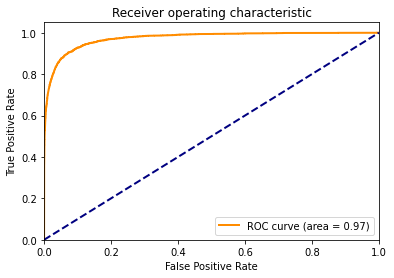

In [31]:
# Построение ROC-кривой
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Выводы

Исходя из проведенного анализа, можно сделать вывод, что модель LogisticRegression является наилучшей для решения поставленной задачи классификации. На обучающей выборке значение F1-меры составило 0.7668, а на тестовой выборке - 0.7678, что говорит о высокой точности модели.

Матрица ошибок показала, что модель совершает ошибки в классификации на 1140 ложно-положительных случаях и 468 ложно-отрицательных случаях. Однако, в данном случае, ложно-положительные предсказания не являются критичными, так как в дальнейшем они будут отфильтрованы при модерации.

Таким образом, для решения поставленной задачи классификации рекомендуется использовать модель LogisticRegression.